## Data Exploration & Evaluation

In [16]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.mixture import GaussianMixture as GM
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
import matplotlib as mpl
from hdf5manager import hdf5manager as h5
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import scipy
from pandas import pandas as pd

from pandas import DataFrame
from skimage.measure import label, regionprops
from scipy.ndimage.filters import gaussian_filter, convolve
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
import cv2
import os
import seaborn as sns
sns.set()
import csv
from sklearn.datasets.base import Bunch

In [17]:
#Open file
path = '/Users/jcrndm/Documents/'
file = 'test_angs_mags_metrics.csv'

tsv_output_file = path + file
data = pd.DataFrame.from_csv(tsv_output_file)

print(data.head())

/Users/jcrndm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


   mov.mean  mov.std  mov.mode  mov.range  mov.eventrest  mov.maxeventval  \
0       0.0      0.0      3675        0.0              0              0.0   
1       0.0      0.0      3675        0.0              0              0.0   
2       0.0      0.0      3675        0.0              0              0.0   
3       0.0      0.0      3675        0.0              0              0.0   
4       0.0      0.0      3675        0.0              0              0.0   

   mov.surfarea  mov.totalmag  mov.firstder  mov.secder  ...  mov.timetoevent  \
0             0           0.0           0.0         0.0  ...              114   
1             0           0.0           0.0         0.0  ...              113   
2             0           0.0           0.0         0.0  ...              112   
3             0           0.0           0.0         0.0  ...              111   
4             0           0.0           0.0         0.0  ...              110   

   move.timefromevent  brain.data  brain.eventrest

In [18]:
%matplotlib inline

col_list = list(data)

#puts the paramter on a scale of 0 to 1
data -= data.min()
data /= data.max()
data = data.fillna(value=0)

# print(data.head())

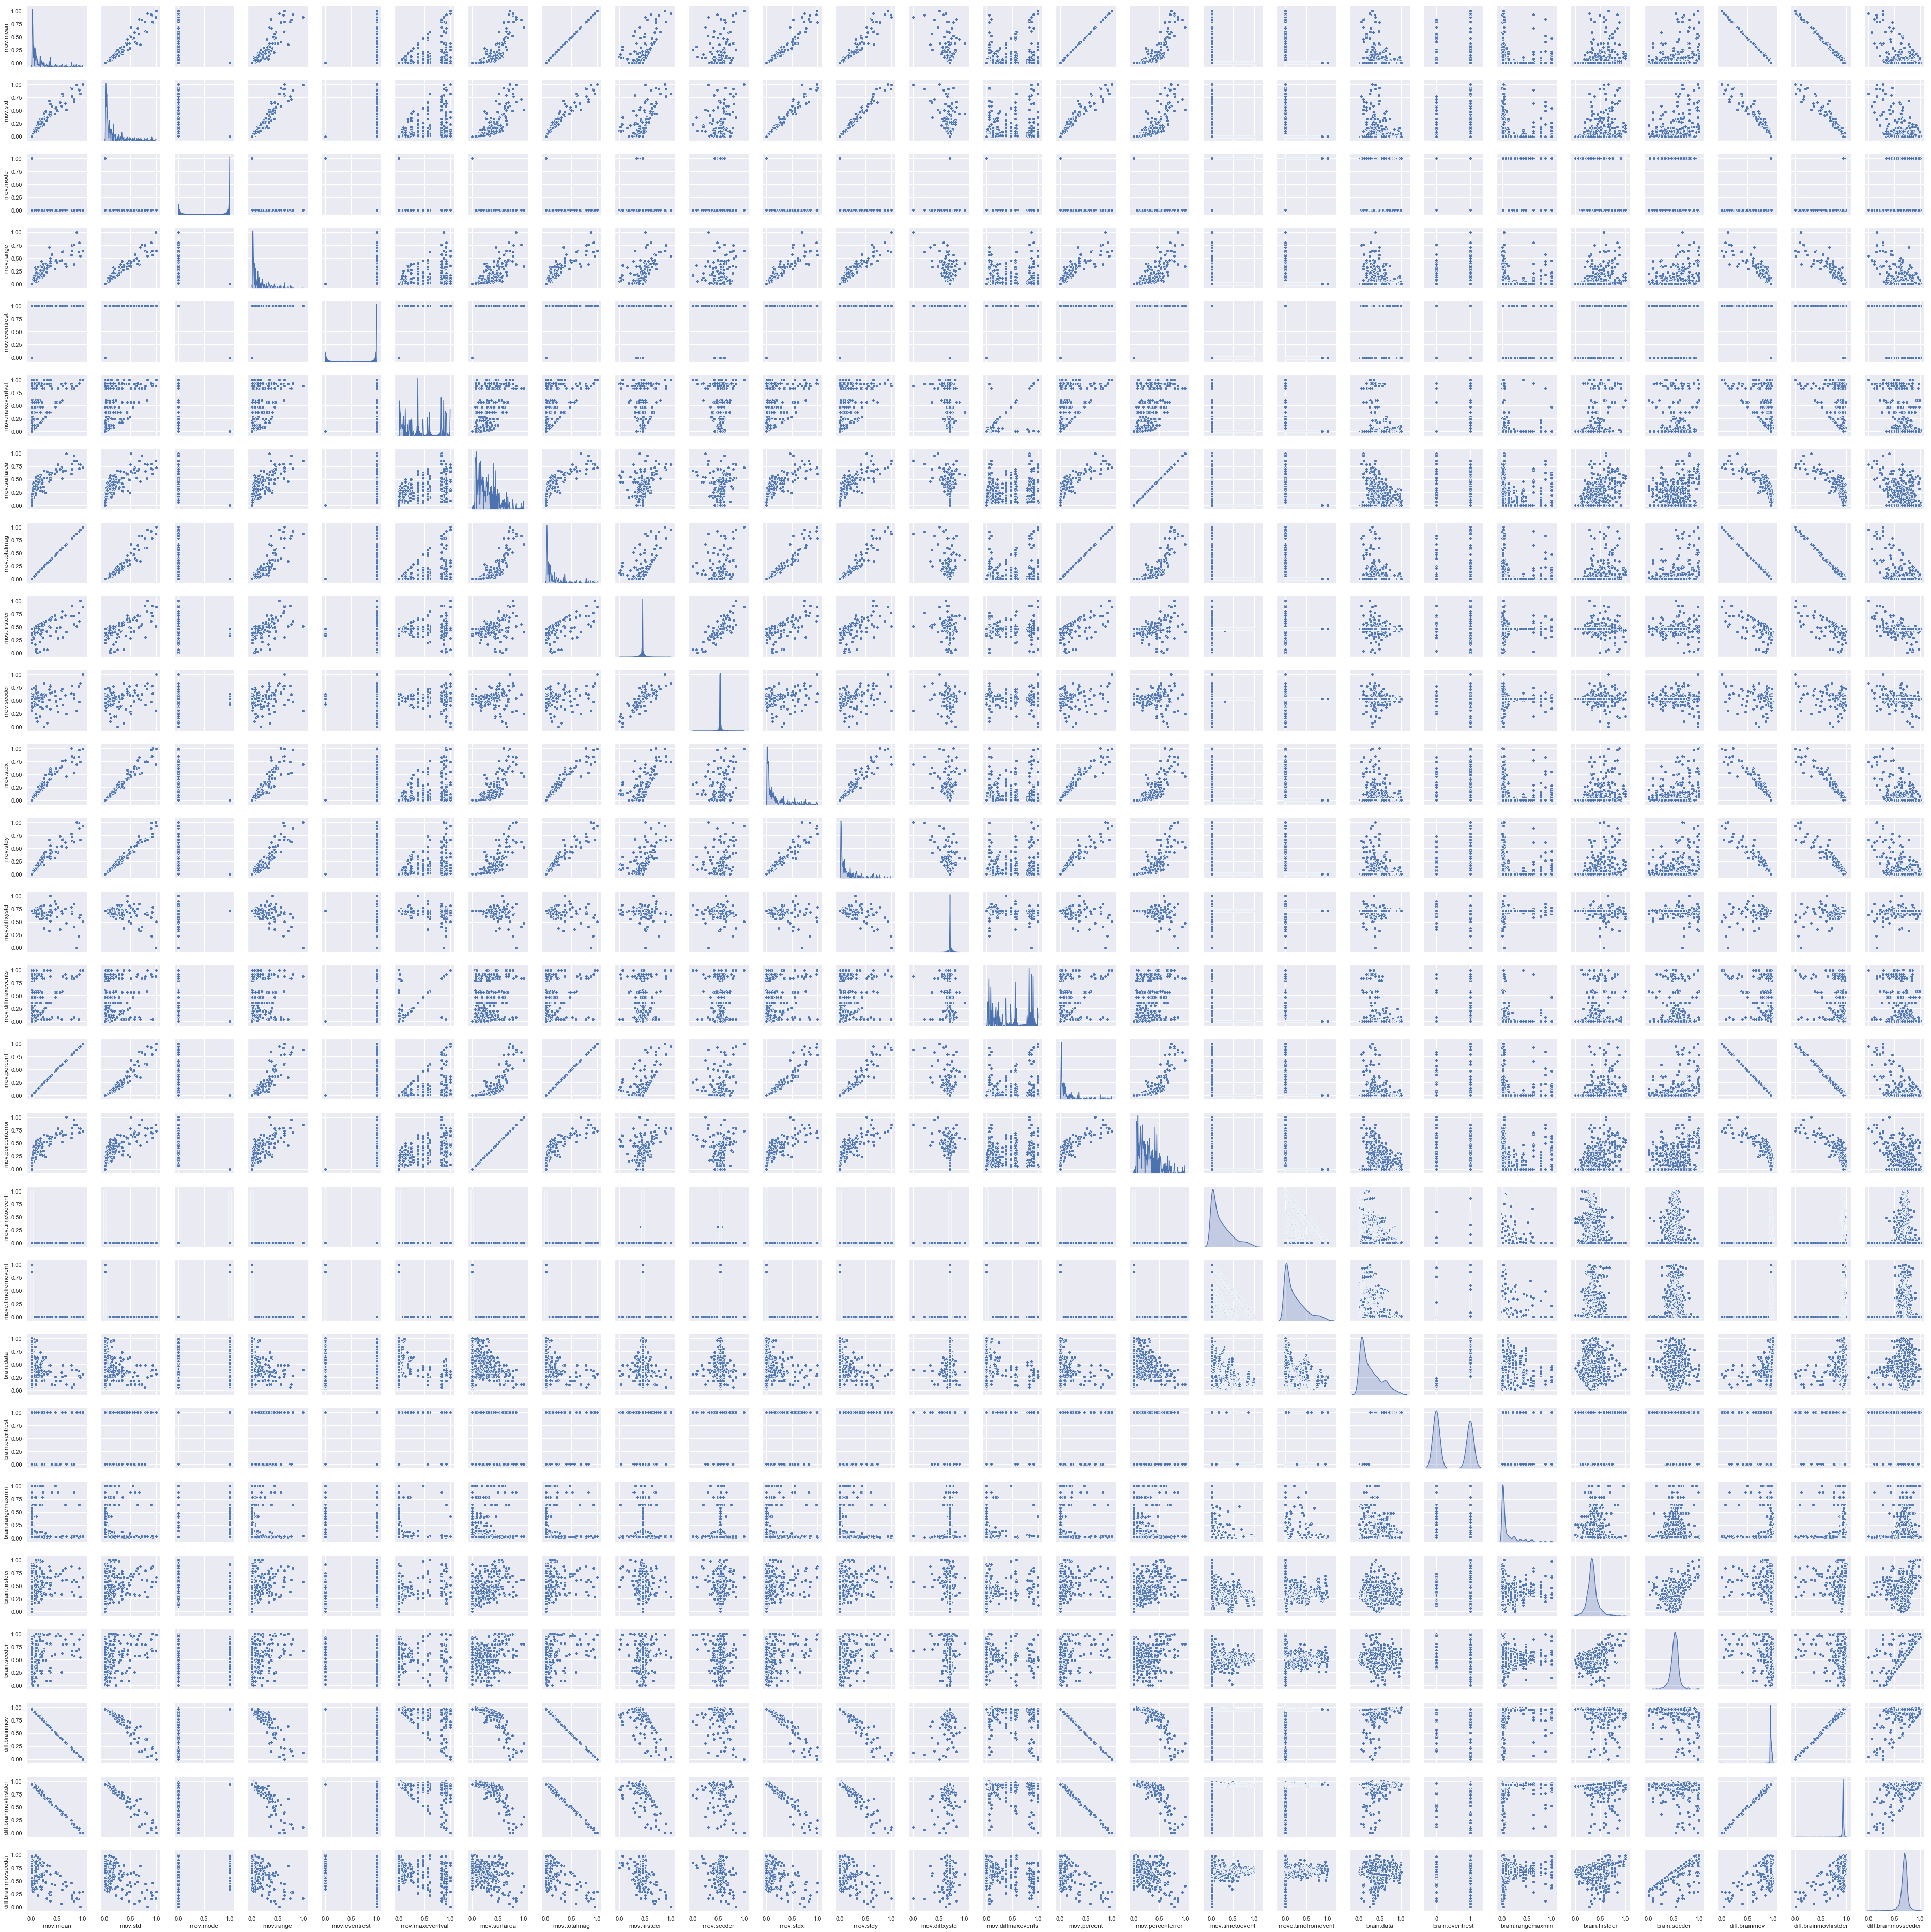

In [19]:
# # Both temporal and spatial metrics visualize  
sns.pairplot(data, diag_kind="kde", height = 2)

plt.savefig('/Users/jcrndm/Documents/metrics_pairplot.png')
# # plt.show()

In [9]:
print(data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 1.0)].index)
data = data.astype('float16')
data['classification'] = np.zeros(len(data))
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 1.0)].index] = 0
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 0.0) & (data['brain.eventrest'] == 0.0)].index] = 1
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 1.0) & (data['brain.eventrest'] == 1.0)].index] = 2
data['classification'].iloc[data.loc[(data['mov.eventrest'] == 1.0) & (data['brain.eventrest'] == 0.0)].index] = 3

Int64Index([ 129,  130,  132,  133,  134,  135,  141,  142,  143,  144,
            ...
            3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999],
           dtype='int64', length=1513)


/Users/jcrndm/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
plt.imshow(data.corr().values, aspect = 'auto', cmap = 'cubehelix')
plt.colorbar()


In [ ]:
sns.pairplot(data, 
             diag_kind="kde", height = 2, 
             markers=["o", "o", "o", "o"], 
             hue_order = [0, 1, 2, 3], hue='classification', palette = "BuGn_r")

plt.savefig('/Users/jcrndm/Documents/metrics_pairplot.png')

In [ ]:
X, y = make_blobs(n_samples=150, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

n_components = np.arange(1, 30)
# n_components_frame = pd.DataFrame()
# n_components = data 

models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X) for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

gmm = GaussianMixture(n_components=4)
gmm.fit(X)


labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis');

In [ ]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
# plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
#                     left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

In [ ]:
def load_my_fancy_dataset():
    with open('/Users/jcrndm/Documents/test_angs_mags_metrics.csv') as csv_file:
        data_file = csv.reader(csv_file)
        temp = next(data_file)
        for i in temp:
            print (i) 
        
#         n_samples = temp[0]
#         n_features = temp[1]
        print(n_samples)
#         print(n_features)
        data = np.empty((n_samples, n_features))
        target = np.empty((n_samples,), dtype=np.int)

        for i, sample in enumerate(data_file):
            data[i] = np.asarray(sample[:-1], dtype=np.float64)
            target[i] = np.asarray(sample[-1], dtype=np.int)

    return Bunch(data=data, target=target)

load_my_fancy_dataset()

In [ ]:
data = pd.DataFrame.from_csv('/Users/jcrndm/Documents/test_angs_mags_metrics.csv')
data.head()
data.columns.tolist()
data.values

In [ ]:
gmm = GaussianMixture(n_components = len(data.values))

colors = ['navy', 'turquoise', 'darkorange']

def make_model():
    def make_ellipse(gmm, ax):
        for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
#         v, w = np.linalg.eigh(covariances)
#         u = w[0] / np.linalg.norm(w[0])
#         angle = np.arctan2(u[1], u[0])
#         angle = 180 * angle / np.pi  # convert to degrees
#         v = 2. * np.sqrt(2.) * np.sqrt(v)
#         ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
#                                   180 + angle, color=color)
#         ell.set_clip_box(ax.bbox)
#         ell.set_alpha(0.5)
#         ax.add_artist(ell)
#         ax.set_aspect('equal', 'datalim')


In [10]:
indices = []
for i in range(len(data["mov.mean"])):
    if i >= 1445 and i < 2388:
        indices.append(1)
    else:
        indices.append(0)

data = data.astype('float64')
a = np.zeros(len(data))
a[1445:2388]=1
data['classification'] = a
# data['classification'].iloc[indices == 0] = 0
# data['classification'].iloc[indices == 1] = 1
c = ["blue", "red"]
print(indices[1500])
print(data["classification"][1500])
print(data.loc[1500, "classification"])
# sns.pairplot(data, 
#              diag_kind="kde", 
#              markers=["o", "o"], 
#              hue_order = [0, 1], hue='classification', palette = c)
plt.savefig('/Users/jcrndm/Documents/metrics_small_pairplot.png')

1
1.0
1.0


<Figure size 432x288 with 0 Axes>

In [15]:
import statsmodels.api as sm
from scipy import stats 


new_vars = ["mov.mean", "mov.range", "mov.maxeventval", "mov.surfarea", "mov.totalmag", "mov.percent",
                "mov.percenterror", "mov.stdx", "mov.stdy", "mov.diffxystd", "mov.maxeventval", "brain.data",
                "brain.rangemaxmin", "diff.brainmov"] 

zeros = np.where(data["classification"] == 0)[0]
ones = np.where(data["classification"] == 1)[0]

for i in range(len(new_vars)):
#     logit_model = sm.Logit(data["classification"], data[new_vars[i]])
    results = stats.ttest_ind(data[new_vars[i]][zeros], data[new_vars[i]][ones])
    print(results)

Ttest_indResult(statistic=0.3404258138502651, pvalue=0.7335537671694952)
Ttest_indResult(statistic=-1.903442523802041, pvalue=0.057054572145488446)
Ttest_indResult(statistic=1.8705836104742484, pvalue=0.06147582171196679)
Ttest_indResult(statistic=-6.3723392849343625, pvalue=2.0727720431107548e-10)
Ttest_indResult(statistic=0.33995143311591597, pvalue=0.7339109609934611)
Ttest_indResult(statistic=0.33377479283367323, pvalue=0.7385670108664902)
Ttest_indResult(statistic=-6.3722995552308, pvalue=2.0733038231647408e-10)
Ttest_indResult(statistic=-1.182063697905223, pvalue=0.23725072677903766)
Ttest_indResult(statistic=-0.573353876140729, pvalue=0.5664373609511741)
Ttest_indResult(statistic=-2.1551131135361836, pvalue=0.03121250743299967)
Ttest_indResult(statistic=1.8705836104742484, pvalue=0.06147582171196679)
Ttest_indResult(statistic=-70.41866334325617, pvalue=0.0)
Ttest_indResult(statistic=-5.791231091705004, pvalue=7.52444581553866e-09)
Ttest_indResult(statistic=-11.336617899472058, p